### Neurolib Attempt

In [1]:
%load_ext autoreload
%autoreload 2

from Jansen_Rit_Neurolib_Model import UniformlyDistributedNoise, JansenRitNode, SingleJansenRitMass, JansenRitNetwork
import matplotlib.pyplot as plt
import numpy as np
import symengine as se
from IPython.display import display
from jitcdde import input as system_input
from neurolib.models.multimodel import MultiModel, ThalamicNode
from neurolib.models.multimodel.builder.base.constants import LAMBDA_SPEED
from neurolib.models.multimodel.builder.base.network import Network, Node
from neurolib.models.multimodel.builder.base.neural_mass import NeuralMass
from neurolib.utils.functions import getPowerSpectrum
from neurolib.utils.stimulus import Input, OrnsteinUhlenbeckProcess, StepInput
from neurolib.utils.loadData import Dataset
import neurolib.utils.functions as func
from neurolib.models.wc import WCModel
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import cm
import scipy

In [2]:
# First we load the structural data set from the Human Connectome Project 
ds = Dataset("hcp")

In [5]:
#odel.params['duration'] = 3000

'''
model.params['exc_ext_baseline'] = 0.5 # Subcortical input level to each neural mass is 500 spikes / s
model.params['inh_ext_baseline'] = 0.5

model.params['dt'] = 2 # ms 2ms from paper
model.params['signalV'] = 2.0 # time delay for coupling

model.params['duration'] = 20 * 1000 # 20 seconds
model.params['sigma_ou'] = 1 # Noise Intensity = 1

model.params['c_excinh'] = 32 # Connection strength between main population of excitatory neurons and inhibitory neurons
model.params['c_inhexc'] = 3 # Connection strength between inhibitory neurons and main population of excitatory neurons

model.params['K_gl'] = 1 # Gain factor between neural masses 

model.params['mu_exc'] = 7 
model.params['mu_inh'] = 7 

print(model.params['dt'])
'''


model = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params['exc_ext'] = 0.65
#model.params['dt'] = 2 # ms 2ms from paper
model.params['signalV'] = 0
model.params['duration'] = 20 * 1000 
model.params['sigma_ou'] = 0.14
model.params['K_gl'] = 3.15
model.params['sampling_dt'] = 2

print(model.params['chunksize'])

KeyError: 'chunksize'

In [279]:
model.run(chunkwise=True)

(0.0, 200.0)

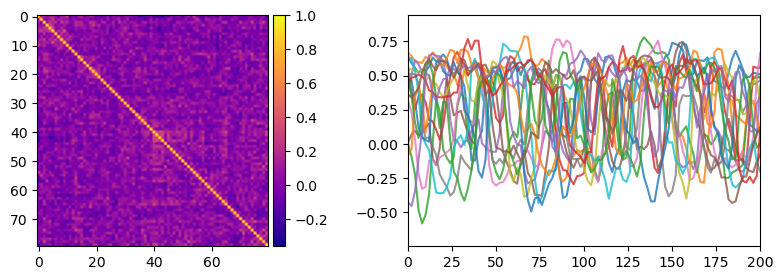

In [280]:
# a nice color map
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
fc = func.fc(model.exc[:, -model.exc.shape[1]//2:])
im = axs[0].imshow(fc, cmap='plasma')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)

axs[1].plot(model.t, model.exc[::5, :].T, alpha=0.8);
axs[1].set_xlim(0, 200)


In [269]:
print(model.exc.shape)
print(model.params['dt'])

(80, 10000)
0.1


In [3]:
from mne_connectivity import spectral_connectivity_epochs

In [266]:
conn = spectral_connectivity_epochs(
	X,
	method="dpli",
	sfreq=250,
    fmin=8,
    fmax=30,
	verbose=False,
    faverage=True
)

ValueError: operands could not be broadcast together with shapes (80,80,221) (221,80,80) 

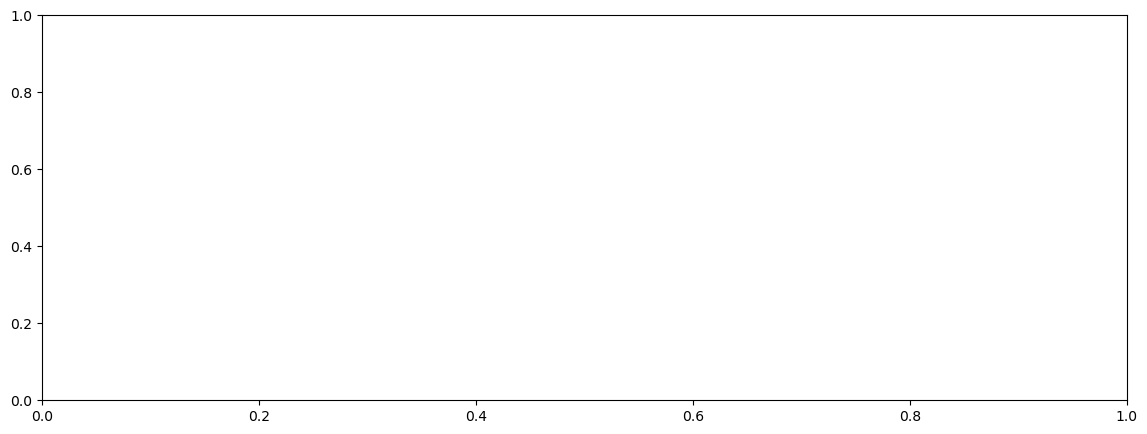

In [258]:
fig, axs = plt.subplots(1, 1, figsize=(14, 5), sharey=True)
axs.imshow(symmetrize(conn.get_data("dense")), vmin=0, vmax=1)
axs.set_title("dPLI")

In [4]:
def symmetrize(a):
    return a + a.T - np.diag(np.diag(a))

data = symmetrize(conn.get_data("dense")[:, :, 0])

avg = data.mean(axis=1)
print(avg.shape)

NameError: name 'conn' is not defined

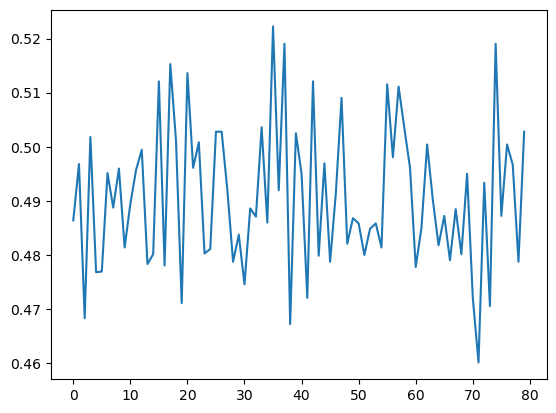

In [182]:
plt.plot(avg)

Done with 6, 32.5, 0.006327777343749999, 0.40893750000000006
Done with 7, 30, 0.007151871093749996, 0.4105625
Done with 7, 32.5, 0.008701937499999998, 0.46699999999999997
Done with 7, 35, 0.008004589843749998, 0.4415625
Done with 7, 37.5, 0.005757828124999998, 0.452125
Done with 10, 27.5, 0.006808402343749997, 0.4654375
Done with 10, 30, 0.008123589843749997, 0.41556250000000006
Done with 10, 32.5, 0.009447183593749997, 0.45443750000000005
Done with 10, 35, 0.009187402343749998, 0.45718749999999997


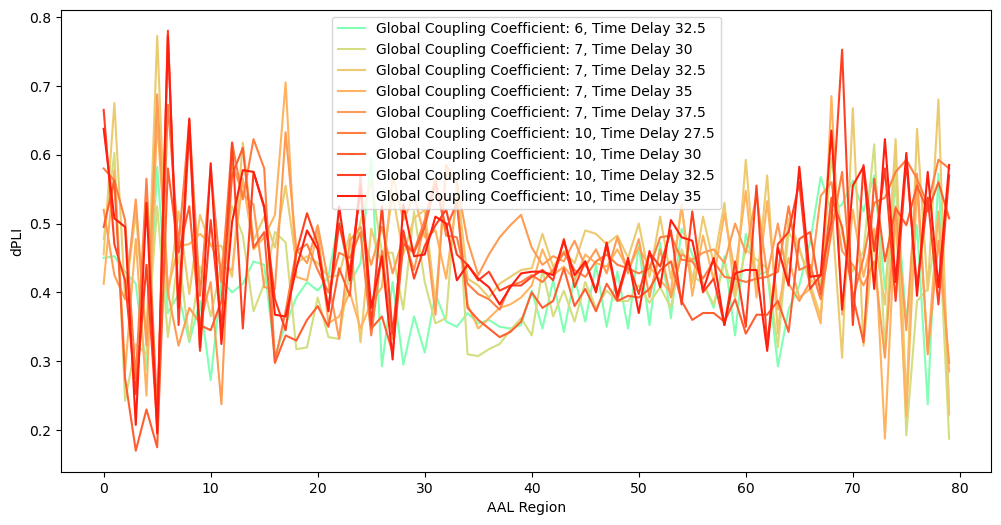

In [88]:
color = cm.rainbow(np.linspace(0, 1, 25))
plt.subplots(figsize=(12, 6))
for i, k_gl in enumerate([3, 5, 6, 7, 10]):
    #for j, signalV in enumerate([0, 5  , 10, 20, 30]):
    for j, signalV in enumerate([27.5, 30, 32.5, 35, 37.5]):
        model = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
        model.params['signalV'] = signalV
        model.params['K_gl'] = k_gl
        model.params['duration'] = 1 * 1000 
        
        trials = []
        for trial in range(5):
            model.run(chunkwise=True, chunksize=10000)
            X = model.exc
            X = scipy.signal.resample(X, 250, axis=1)
            trials.append(X)
        X = np.array(trials)

        conn = spectral_connectivity_epochs(
            X,
            method="dpli",
            sfreq=250,
            fmin=8,
            fmax=30,
            verbose=False,
        )

        data = symmetrize(conn.get_data("dense")[:, :, 0])
        avg = data.mean(axis=1)
        if np.any(avg > 0.75) or np.any(avg < 0.25):
            plt.plot(avg, label=f"Global Coupling Coefficient: {k_gl}, Time Delay {signalV}", c = color[i*5 + j])
            print(f"Done with {k_gl}, {signalV}, {avg.var()}, {avg.mean()}")
plt.xlabel("AAL Region")
plt.ylabel("dPLI")
plt.legend()
plt.show()

In [89]:
model = WCModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params['signalV'] = 32.5
model.params['K_gl'] = 10
model.params['duration'] = 20 * 1000
model.run(chunkwise=True, chunksize=20000)
d = model.exc
print(x.shape)
d = scipy.signal.resample(x, 5000, axis=1)
low_sos = scipy.signal.butter(3, 32, 'low', output='sos', fs=250)
high_sos = scipy.signal.butter(3, 8, 'high', output='sos', fs=250)
d = scipy.signal.sosfilt(high_sos, scipy.signal.sosfilt(low_sos, d))
print(d.shape)

(20, 2)
(20, 5000)


In [90]:
import ordpy
from ordpy import maximum_complexity_entropy, minimum_complexity_entropy

hc_min_curve = minimum_complexity_entropy(dx=5, dy=1, size=200).T
hc_max_curve = maximum_complexity_entropy(dx=5, dy=1, m=10).T
hmin, cmin = hc_min_curve  
hmax, cmax = hc_max_curve
T_max = d.shape[1]
window_size = 250
windows = []
for i in range(0, T_max, window_size):
	windows.append((i, i + window_size))

In [91]:
x = np.zeros((len(windows), 2))
for idx, (start_idx, end_idx) in enumerate(windows):
    print(start_idx, end_idx)
    x_entropy, x_complexity = ordpy.complexity_entropy(data=d[:, start_idx:end_idx], dx=int(5), dy=int(1), taux=int(3), tauy=int(1))
    x[idx][0] = x_entropy
    x[idx][1] = x_complexity

0 250
250 500
500 750
750 1000
1000 1250
1250 1500
1500 1750
1750 2000
2000 2250
2250 2500
2500 2750
2750 3000
3000 3250
3250 3500
3500 3750
3750 4000
4000 4250
4250 4500
4500 4750
4750 5000


/scratch/603323/ipykernel_220134/3711633508.py:11: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend((upper, lower, x_plot), ("Maximum Complexity Entropy", "Minimum Complexity Entropy", "Simulated Data"), scatterpoints=1)


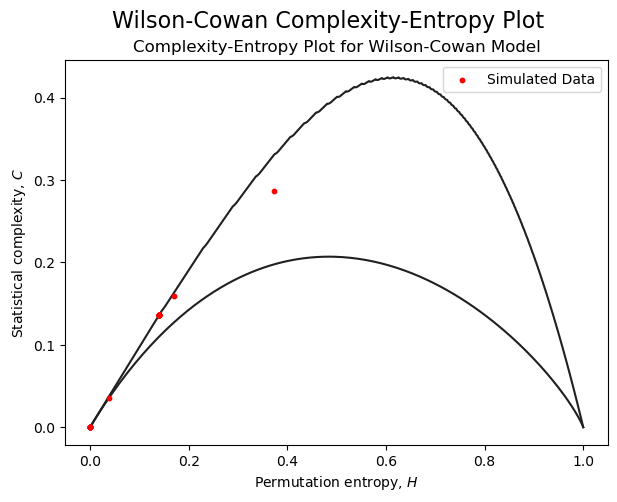

In [93]:
f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.set_ylabel('Statistical complexity, $C$')
f.suptitle('Wilson-Cowan Complexity-Entropy Plot', fontsize=16)
upper = ax.plot(hmin, cmin, linewidth=1.5, color='#202020', zorder=0)
lower = ax.plot(hmax, cmax, linewidth=1.5, color='#202020', zorder=0)
x_plot = ax.scatter(x[:,0], x[:,1], c="r", s=10)
ax.set_title("Complexity-Entropy Plot for Wilson-Cowan Model")
ax.set_ylabel('Statistical complexity, $C$')
ax.set_xlabel('Permutation entropy, $H$')
ax.legend((upper, lower, x_plot), ("Maximum Complexity Entropy", "Minimum Complexity Entropy", "Simulated Data"), scatterpoints=1)
plt.show()

In [94]:
print(x)


[[ 0.37290455  0.28695157]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [ 0.16934519  0.15917052]
 [ 0.14057709  0.13674801]
 [ 0.14057709  0.13674801]
 [ 0.14057709  0.13674801]
 [ 0.14057709  0.13674801]
 [ 0.14057709  0.13674801]
 [ 0.14057709  0.13674801]
 [ 0.14057709  0.13674801]
 [ 0.14057709  0.13674801]
 [ 0.14057709  0.13674801]
 [ 0.03744786  0.03596836]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]]
